In [341]:
import numpy as np
import galois
import imageio.v3 as iio
import matplotlib.pyplot as plt

# Define the binary field GF(2)
GF2 = galois.GF(2)

# Define the irreducible polynomial used to construct GF(2^8)
# Polynomial: x^8 + x^4 + x^3 + x + 1 (represented by the binary vector)
irreducible_poly = galois.Poly([1,0,0,0,1,1,0,1,1], field = GF2)

# Define the extension field GF(2^8) using the given irreducible polynomial
Gfield = galois.GF(2**8, irreducible_poly = irreducible_poly)

## Shift rows

In [342]:
def shiftRows(stateMatrix):

    # Applies AES ShiftRows step: 
    # Each row is cyclically shifted to the left by its row index
    return Gfield(np.array([np.roll(row, shift = -i) for i, row in enumerate(stateMatrix)]))

## Add round key

In [343]:
def addRoundKey(stateMatrix, w, i):

    # XOR the current state matrix with the round key extracted from w
    # w is the key schedule, and i is the round number
    return stateMatrix + w[i * 4: i*4 + 4, :].transpose()

## Mix columns

In [344]:

def mixColumns(stateMatrix):

    # Applies AES MixColumns transformation
    # Each column of the state is multiplied by a fixed matrix (defined below)
    A = Gfield(np.array([[0x02, 0x03, 0x01, 0x01],
                         [0x01, 0x02, 0x03, 0x01],
                         [0x01, 0x01, 0x02, 0x03],
                         [0x03, 0x01, 0x01, 0x02]]))
    
    # Matrix multiplication in GF(2^8)
    return A @ stateMatrix

## Sub bytes

In [345]:
def getIndexFromHex(input):

    # Extracts row and column index from a byte
    # Upper 4 bits = row index, lower 4 bits = column index
    return (input & 0xF0) >> 4, input & 0xF

# 16x16 AES substitution box (S-box) used for the SubBytes step
# Maps each byte to a nonlinear substitution value
sbox = np.array([
                [0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76],
                [0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0],
                [0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15],
                [0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75],
                [0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84],
                [0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF],
                [0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8],
                [0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2],
                [0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73],
                [0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB],
                [0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79],
                [0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08],
                [0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A],
                [0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E],
                [0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF],
                [0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16],
                ]) # Full S-box omitted here for brevity; already correctly defined


def subBytes(stateMatrix):
    
    # Applies the AES SubBytes step using the S-box
    for i in range(np.shape(stateMatrix)[0]):
        for j in range(np.shape(stateMatrix)[1]):
            x, y = getIndexFromHex(stateMatrix[i, j])
            stateMatrix[i, j] = sbox[x, y]
    return stateMatrix

ref: https://gist.github.com/bonsaiviking/5571001

## Key expansion

In [346]:
def keyExpansion(key): 
    Nk = 4   #number of columns in state (Number of 32-bit words in the key (AES-128 uses 4)
    Nb = 4   #number of 32 bit words in cipher key (Number of columns (words) in the state matrix)
    Nr = 10  #number of rounds for AES-128
    
    # Initialize the key schedule matrix (44 words × 4 bytes = 176 bytes
    w = np.zeros((44, 4), dtype = int)
    
    # First Nk words are taken directly from the original cipher key
    w[:Nk, :] = key.reshape(4,4)
    
    i = Nk
    while i < Nb * (Nr + 1):
        # Copy previous word
        temp = Gfield(w[i - 1,:]) 
        
        if i % Nk == 0:

            # Perform key schedule core:
            # 1. Rotate left (RotWord)
            afterRotWord = np.roll(temp, -1)

            # 2. Apply SubWord (byte-wise substitution using S-box)
            afterSubWord = subWord(afterRotWord)

            # 3. XOR with round constant
            temp = Gfield(afterSubWord) + Gfield(roundConstant(i//Nk))

        # w[i] = w[i - Nk] XOR temp
        w[i, :] = Gfield(w[i - Nk,:]) + temp
        i += 1
    return w

def roundConstant(i):
    if i == 1:
        # First round constant is 0x01 followed by 0s
        return Gfield(np.array([0x01, 0x0, 0x0, 0x0]))
    
    # Subsequent constants are powers of 0x02 in GF(2^8)
    array = Gfield(np.array([0x02, 0x0, 0x0, 0x0]))
    return array**(i-1)

def subWord(vector):

    # Applies the AES S-box substitution to a 4-byte word
    for i in range(np.shape(vector)[0]):
        x, y = getIndexFromHex(vector[i])
        vector[i] = sbox[x, y]
    return vector

## AES Encrypt

In [347]:
def aesEncrypt(stateMatrix, key):

    # Expand the key into round keys using keyExpansion
    # w has shape (44, 4), 11 round keys of 4 words (4x4 each)
    w = Gfield(keyExpansion(key))

    # Initial AddRoundKey step before the first round
    stateMatrix = stateMatrix + w[:4,:4].transpose()    
    
    # Perform 9 full rounds: SubBytes, ShiftRows, MixColumns, AddRoundKey
    for i in range(1, 10):

        # Byte-wise substitution using S-box
        stateMatrix = subBytes(stateMatrix)

        # Rotate rows to the left
        stateMatrix = shiftRows(stateMatrix)

        # Mix columns using linear transformation
        stateMatrix = mixColumns(stateMatrix)

        # XOR with round key for round i
        stateMatrix = addRoundKey(stateMatrix, w, i)
    
    # Final (10th) round – no MixColumns
    stateMatrix = subBytes(stateMatrix)
    stateMatrix = shiftRows(stateMatrix)

    # Final AddRoundKey
    stateMatrix += w[10 * 4: 10 * 4 + 4, :].transpose()

    # Encrypted state (ciphertext)
    return stateMatrix

## Convert string message to hex

In [348]:
def convertStringMessageToHex(message):
    hexArray = [hex(byte) for byte in message.encode()]
    return np.array(hexArray)

print(convertStringMessageToHex("Alfred"))

['0x41' '0x6c' '0x66' '0x72' '0x65' '0x64']


## Convert bitstream to hex

In [349]:
def convertBitArrayToHexArray(bitArray):

    # Step 1: Pad the input bit array to make its length a multiple of 8
    # This ensures proper grouping into full bytes
    # Pad to nearest 8 bits
    padding = (8 - len(bitArray) % 8) % 8
    bitArray = bitArray + [0] * padding 
    
    # Step 2: Convert every 8 bits into an integer (byte)
    # Convert each 8-bit chunk to a byte
    bytes_out = []
    for i in range(0, len(bitArray), 8):

        # Slice 8 bits
        byte = bitArray[i : i+8]

        # Convert bit string to integer
        byte_val = int(''.join(str(b) for b in byte), 2)
        bytes_out.append(byte_val)

    # 2. Optionally convert to hex
    byte_array = bytes_out

    # Step 3: Convert the byte values to hexadecimal strings
    hex_array = [hex(b) for b in byte_array]

    return hex_array


# Example usage: converts bit sequence to ['0x80', '0x1']
convertBitArrayToHexArray([1,0,0,0,0,0,0,0,1])

['0x80', '0x80']

## Convert hexstream to bitstream

In [350]:
def convertHexStreamToBitStream(hexArray):
    bit_list = []

    # Iterate through each byte in the input list
    for byte in hexArray:

        # Convert the byte to an 8-bit binary string (remove '0b' and pad with zeros)
        # Binary string, padded to 8 bits
        bits = bin(byte)[2:].zfill(8)  

        # Convert the binary string to a list of integers and append to the result
        bit_list.extend([int(b) for b in bits])
    return bit_list

# Example usage: converts [0x80, 0x80] to [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
convertHexStreamToBitStream([0x80, 0x80])

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

## Counter mode

In [351]:

def counterMode(message, key, nonce):

    # Flatten the message to an array of bytes
    temp = message.flatten()

    # Prepare an empty output array in GF(2^8)
    output = Gfield(np.array([], dtype=int))

    # Pad the message so its length is a multiple of 16 bytes (AES block size)
    if len(temp) % 16 != 0:
        temp = np.append(temp, np.zeros(16 - len(temp) % 16, dtype=int))

    # Process each 16-byte block of the message
    for i in range(len(temp) // 16):

        # Convert current nonce to a 16-byte array and reshape as 4×4 state matrix
        nonceAsMatrix = Gfield(np.array(list(nonce.to_bytes(16, 'little'))).reshape(4, 4))

        # Encrypt the nonce using AES
        encrypted = aesEncrypt(nonceAsMatrix, key)

        # Extract current plaintext block and reshape into a 4×4 matrix
        stateMatrix = temp[i * 16 : (i + 1) * 16].reshape(4, 4)

        # XOR the AES-encrypted nonce with the plaintext block (as in CTR mode)
        output = np.append(output, (Gfield(encrypted) + Gfield(stateMatrix)).flatten())

        # Increment nonce for the next block
        nonce += 1

    # Remove padding to match original message length
    output = output.flatten()
    output = output[:len(message)]  
    return output





## Test

In [ ]:
def printInHex(stateMatrix):

    # Prints the 4×4 state matrix in hexadecimal format for visualization
    for row in stateMatrix:
        print(" ".join(f"{val:02x}" for val in row))
    print("\n")
        
def runTest():
    # Example plaintext in a 4×4 state matrix format
    # stateMatrix = Gfield(np.array([[0x32, 0x88, 0x31, 0xe0],
    #                                [0x43, 0x5a, 0x31, 0x37],
    #                                [0xf6, 0x30, 0x98, 0x07],
    #                                [0xa8, 0x8d, 0xa2, 0x34]]))
    
    stateMatrix = Gfield(np.array([[0x41, 0x6c, 0x66, 0x62],
                                   [0x65, 0x64, 0x00, 0x00],
                                   [0x00, 0x00, 0x00, 0x00],
                                   [0x00, 0x00, 0x00, 0x00]]))
    
    # AES-128 key (16 bytes)
    testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))

    # Encrypt using AES
    encrypted = aesEncrypt(stateMatrix, testKey)

    # Display original and encrypted matrices
    printInHex(stateMatrix)
    printInHex(encrypted)

def runCounterModeTest():
    message ="""Brian, top marks for not trying
                So kind of you to bless us with your effortlessness
                We're grateful and so strangely comforted


                And I wonder, are you putting us under?
                'Cause we can't take our eyes off the t-shirt and ties combination
                Well, see you later, innovator

                Some want to kiss, some want to kick you
                There's not a net you couldn't slip through
                Or at least that's the impression I get, 'cause you're smooth and you're wet
                And she's not aware yet, but she's yours
                She'll be saying, "Use me, show me the jacuzzi"
                I imagine that it's there on a plate, your high rendezvous rate
                Means that you'll never be frightened to make 'em wait for a while

                I doubt it's your style not to get
                What you set out to acquire, the eyes are on fire
                You are the unforecasted storm, oh"""
    print("Message: \n", message) 
    print()

    # AES-128 test key
    testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))

    # Convert message to byte array (as integers)
    messageAsInt = np.array([byte for byte in message.encode("utf-8")])

    # Encrypt using CTR mode (encryption and decryption are symmetric in CTR)
    cypherText = counterMode(messageAsInt, testKey, 1)

    # Convert ciphertext to UTF-8-safe printable string
    cypherTextBytes = bytes([int(x) for x in cypherText])
    cypherTextString = cypherTextBytes.decode('utf-8', errors='replace')
    print("Cypher Text: \n", cypherTextString)
    print()

    # Decrypt (re-encrypt with same key and nonce)
    decryptedText = counterMode(cypherText, testKey, 1)   

    decrypted_bytes = bytes([int(x) for x in decryptedText])
    decrypted_str = decrypted_bytes.decode('utf-8', errors='replace')
    print("Decrypted String: \n", decrypted_str)
  
    
# runTest()
runCounterModeTest()

41 6c 66 62
65 64 00 00
00 00 00 00
00 00 00 00


06 04 f5 3c
77 b3 4d d2
50 55 96 e1
8d 71 9a 24




## Image to greyscale bytes

In [353]:
def byteArrayToGrayscaleImage(byte_array, shape):
    """
    Reconstructs an 8-bit grayscale image from a flat byte array and target shape.

    Parameters:
        byte_array: 1D NumPy array with values in [0, 255]
        shape: tuple (height, width) – e.g. (256, 256)

    Returns:
        image: 2D NumPy array (dtype=uint8) representing the grayscale image
    """
    expected_size = shape[0] * shape[1]
    if len(byte_array) != expected_size:
        raise ValueError(f"Byte count ({len(byte_array)}) does not match expected size {shape}.")

    # Reshape the flat array into 2D image format
    image = np.array(byte_array, dtype = np.uint8).reshape(shape)
    return image

## Greyscale bytes to image

In [354]:
def grayscaleImageToByteArray(image_path):
    """
    Reads an 8-bit grayscale image and returns a 1D NumPy array of bytes (0–255),
    equivalent to np.array([byte for byte in message.encode('utf-8')]).
    """
    # Read the image
    image = iio.imread(image_path)[:,:,0]

    # Check: must be 2D (grayscale)
    if image.ndim != 2:
        raise ValueError("The image must be grayscale (2D).")

    # Ensure 8-bit format
    image = image.astype(np.uint8)

    # Flatten the image into a 1D byte array
    byte_array = np.array(image.flatten(), dtype=np.uint8)

    return byte_array

## Test of converting image to bytes and encryption of those

In [355]:
# Convert the image into a flat byte array (1D NumPy array of uint8 values)
byte_array = grayscaleImageToByteArray("dog.png")

# Print all byte values from the image (flattened)
print(byte_array) 
print()

# Print the total number of bytes (i.e., pixels in the grayscale image)
print(f"Length: {len(byte_array)} bytes")


[ 59  61  61 ... 123 130 130]

Length: 273280 bytes


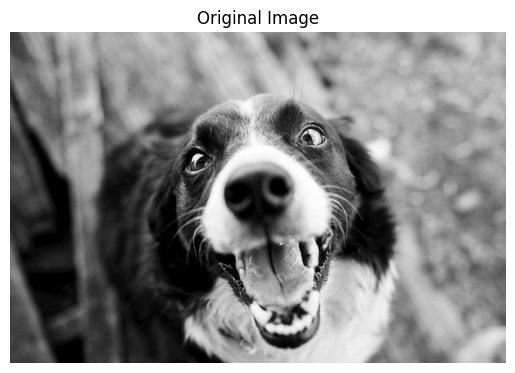

In [356]:
# Assume known dimensions
shape = (427, 640)  # ← Adjust this to match the actual image size!

# Original image
original_image = byteArrayToGrayscaleImage(byte_array, shape)

# Display the image
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


In [ ]:
testKey = Gfield(np.array([0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]))

# Encrypt the grayscale byte array using AES in CTR mode
cypherImageBytes = counterMode(byte_array, testKey, 1)

# Print the encrypted byte values
print("Cipher image bytes:\n", cypherImageBytes)
print()

# Decrypt the image by reapplying AES CTR with the same key and nonce
decryptedText = counterMode(cypherImageBytes, testKey, 1)

# Print the decrypted byte values (should match the original image)
print("Decrypted image bytes:\n", decryptedText)


## Transform bytes into greyscale image

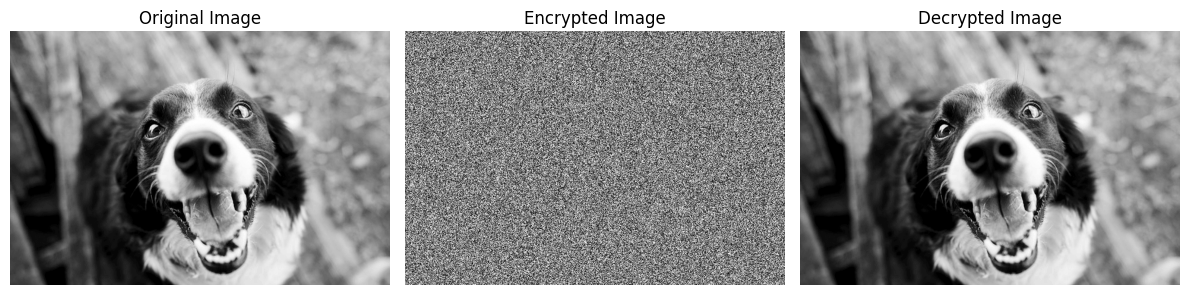

In [ ]:
# Assume known image dimensions

# Reconstruct images from byte arrays
encrypted_image = byteArrayToGrayscaleImage(cypherImageBytes, shape)
restored_image = byteArrayToGrayscaleImage(decryptedText, shape)

# Plot side by side
import matplotlib.pyplot as plt

# 1 row, 2 columns
fig, ax = plt.subplots(1, 3, figsize=(12, 6))  


# Left: original image
ax[0].imshow(original_image, cmap = "gray")
ax[0].set_title("Original Image")
ax[0].axis('off')

# Middle: encrypted image
ax[1].imshow(encrypted_image, cmap='gray')
ax[1].set_title("Encrypted Image")
ax[1].axis('off')

# Right: decrypted (original) image
ax[2].imshow(restored_image, cmap='gray')
ax[2].set_title("Decrypted Image")
ax[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
(original_image - restored_image).max(), (original_image - restored_image).min()

(0, 0)